### Wasserstein GAN with Gradient Penalty 
https://arxiv.org/pdf/1704.00028.pdf
the paper is by 
Ishaan Gulrajani, Faruk Ahmed, Martin Arjovsky, Vincent Dumoulin and Aaron Courville

This implementation is based on pytorch implementation by ChenKaiXuSan
https://github.com/ChenKaiXuSan/WassersteinGAN-PyTorch


Define
$$
G: v \sim \mathcal{N}^k(0,1)  \rightarrow  R^m
$$
$$
D: R^m \rightarrow [0,1]
$$

The classic GAN model is defined by a discriminator D and a Generator G.  Together they work through the classic min-max game:

$$
\min_G \max_D \mathbf{E}_{x \sim \mathbf{P}_r } [log(D(x)] - \mathbf{E}_{\tilde x \sim \mathbf{P}_g }[ 1- log(D(\tilde x)) ]
$$

where Pr is the data distribution and Pg is the model distribution implicitly defined by x˜ =
G(z), z ∼ p(z) 

With GAN-div we train the discriminator with the modified loss function
$$
\mathbf{L} ~=~ \mathbf{E}_{\tilde x \sim \mathbf{P}_g }[D( \tilde x)) ]- \mathbf{E}_{x \sim \mathbf{P}_r } [D(x)] - 
k \mathbf{E}_{\hat x \sim \mathbf{P}_{ \hat x }} [(|| \nabla_{\hat x} D(\hat x)||^p ]
$$
where the gradient is taken over samples drawn on straight lines between read data and generated samples.


In [1]:
class Config(object):
    def __init__(self):
        super(Config, self).__init__()
        self.model='dcgan' 
        self.adv_loss='wgan-div' 
        self.img_size=64
        self.channels=3
        self.g_num=5
        self.z_dim=100
        self.g_conv_dim=64
        self.d_conv_dim=64
        self.lambda_gp=10.0
        self.version='test'
        self.clip_value=0.01
        # Training setting
        self.epochs=5000 
        self.batch_size=32 
        self.num_workers=2
        # TTUR 
        self.g_lr=0.0001
        self.d_lr=0.0004 
        self.beta1=0.5
        self.beta2=0.999

        # using pretrained
        self.pretrained_model=None

        # Misc
        self.train=True
        self.parallel=False
        self.dataset='galaxy'
        self.use_tensorboard=False 
        # Path
        self.dataroot="C:/Users/denni/OneDrive/Docs9/gan/galaxies4" 
        self.log_path='./logs'
        self.model_save_path='./models' 
        self.sample_path='./samples' 
        # Step size
        self.log_step=100
        self.sample_step=1000 
        self.model_save_step=1000
import os
import utils
config = Config()
print(config.model)        

dcgan


In [2]:
# %%
'''
pure dcgan structure.
code similar sample from the pytorch code.
https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
'''
import torch
import torch.nn as nn

import numpy as np
# %%
class Generator(nn.Module):
    '''
    pure Generator structure

    '''    
    def __init__(self, batch_size, image_size=64, z_dim=100, conv_dim=64, channels = 3, n_classes = 3):
        
        super(Generator, self).__init__()
        self.imsize = image_size
        self.channels = channels
        self.batch_size = batch_size
        self.z_dim = z_dim

        repeat_num = int(np.log2(self.imsize)) - 3  # 3
        mult = 2 ** repeat_num  # 8

        self.l1 = nn.Sequential(
            # input is Z, going into a convolution.
            nn.ConvTranspose2d(self.z_dim, conv_dim * mult, 4, 1, 0, bias=False),
            nn.BatchNorm2d(conv_dim * mult),
            nn.ReLU(True)
        )

        curr_dim = conv_dim * mult

        self.l2 = nn.Sequential(
            nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(curr_dim / 2)),
            nn.ReLU(True)
        )

        curr_dim = int(curr_dim / 2)

        self.l3 = nn.Sequential(
            nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(curr_dim / 2)),
            nn.ReLU(True),
        )

        curr_dim = int(curr_dim / 2)

        self.l4 = nn.Sequential(
            nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(curr_dim / 2)),
            nn.ReLU(True)
        )
        
        curr_dim = int(curr_dim / 2)
        
        self.last = nn.Sequential(
            nn.ConvTranspose2d(curr_dim, self.channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(z.size(0), -1, 1, 1) # (*, 100, 1, 1)
        out = self.l1(z)
        out = self.l2(out)
        out = self.l3(out)
        out = self.l4(out)

        out = self.last(out)

        return out



In [3]:
# %%
class Discriminator(nn.Module):
    '''
    pure discriminator structure

    '''
    def __init__(self, batch_size, n_classes = 3, image_size = 64, conv_dim = 64, channels = 3):
        super(Discriminator, self).__init__()
        self.imsize = image_size
        self.channels = channels

        self.l1 = nn.Sequential(
            nn.Conv2d(self.channels, conv_dim, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )

        curr_dim = conv_dim

        self.l2 = nn.Sequential(
            nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(curr_dim * 2),
            nn.LeakyReLU(0.2, inplace=True)
        )

        curr_dim = curr_dim * 2

        self.l3 = nn.Sequential(
            nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1),
            nn.BatchNorm2d(curr_dim * 2),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        curr_dim = curr_dim * 2

        self.l4 = nn.Sequential(
            nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1),
            nn.BatchNorm2d(curr_dim * 2),
            nn.LeakyReLU(0.2, inplace=True)
        )

        curr_dim = curr_dim * 2
        
        # output layers
        self.last_adv = nn.Sequential(
            nn.Conv2d(curr_dim, 1, 4, 1, 0, bias=False),
            # without sigmoid, used in the loss funciton
            )

    def forward(self, x):
        out = self.l1(x) # (*, 64, 32, 32)
        out = self.l2(out) # (*, 128, 16, 16)
        out = self.l3(out) # (*, 256, 8, 8)
        out = self.l4(out) # (*, 512, 4, 4)
        
        validity = self.last_adv(out) # (*, 1, 1, 1)

        return validity.squeeze()

In [4]:
import os 
import time
import torch
import datetime

import torch.nn as nn 
import torchvision
from torchvision.utils import save_image

import numpy as np

import sys 
sys.path.append('.')
sys.path.append('..')

from utils import *

# %%
class Trainer_dcgan(object):
    def __init__(self, data_loader, config):
        super(Trainer_dcgan, self).__init__()

        # data loader 
        self.data_loader = data_loader

        # exact model and loss 
        self.model = config.model
        self.adv_loss = config.adv_loss

        # model hyper-parameters
        self.imsize = config.img_size 
        self.g_num = config.g_num
        self.z_dim = config.z_dim
        self.channels = config.channels
        self.g_conv_dim = config.g_conv_dim
        self.d_conv_dim = config.d_conv_dim
        self.parallel = config.parallel
        self.clip_value = config.clip_value

        self.lambda_gp = config.lambda_gp
        self.epochs = config.epochs
        self.batch_size = config.batch_size
        self.num_workers = config.num_workers 
        self.g_lr = config.g_lr
        self.d_lr = config.d_lr 
        self.beta1 = config.beta1
        self.beta2 = config.beta2
        self.pretrained_model = config.pretrained_model

        self.dataset = config.dataset 
        self.use_tensorboard = config.use_tensorboard
        # path
        self.image_path = config.dataroot 
        self.log_path = config.log_path
        self.sample_path = config.sample_path
        self.log_step = config.log_step
        self.sample_step = config.sample_step
        self.version = config.version
        self.model_save_step = config.model_save_step

        # path with version
        self.log_path = os.path.join(config.log_path, self.version)
        self.sample_path = os.path.join(config.sample_path, self.version)
        self.model_save_path = config.model_save_path

        if self.use_tensorboard:
            self.build_tensorboard()

        self.build_model()
        
    def load_models(self):
        self.G = Generator(batch_size = self.batch_size, image_size = self.imsize, z_dim = self.z_dim, conv_dim = self.g_conv_dim, channels = self.channels).cuda()
        self.D = Discriminator(batch_size = self.batch_size, image_size = self.imsize, conv_dim = self.d_conv_dim, channels = self.channels).cuda()
        # optimizer 
        if self.adv_loss == 'wgan':
            # the original wgan use the RMSprop optimizer.
            self.g_optimizer = torch.optim.RMSprop(self.G.parameters(), self.g_lr)
            self.d_optimizer = torch.optim.RMSprop(self.D.parameters(), self.d_lr)
        else:
            self.g_optimizer = torch.optim.Adam(self.G.parameters(), self.g_lr, [self.beta1, self.beta2])
            self.d_optimizer = torch.optim.Adam(self.D.parameters(), self.d_lr, [self.beta1, self.beta2])


        checkpoint = torch.load(self.model_save_path+"/saved_model")
        self.D.load_state_dict(checkpoint['disc_state_dict'])
        self.G.load_state_dict(checkpoint['gen_state_dict'])

        self.d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
        self.g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])

        #epoch = checkpoint['epoch']
        #loss = checkpoint['loss']
        print(self.G)
        print(self.D)

        print("models restored")
        
    
    def save_models(self):
           torch.save({
                'disc_state_dict': self.D.state_dict(),
                'd_optimizer_state_dict': self.d_optimizer.state_dict(),
                'gen_state_dict': self.G.state_dict(),
                'g_optimizer_state_dict': self.g_optimizer.state_dict(),
                }, self.model_save_path+"/saved_model")
     

    def train(self):
        '''
        Training
        '''

        # fixed input for debugging
        fixed_z = tensor2var(torch.randn(self.batch_size, self.z_dim)) # （*, 100）

        for epoch in range(self.epochs+1):
            # start time
            start_time = time.time()

            for i, (real_images, _) in enumerate(self.data_loader):

                # configure input 
                if self.adv_loss == 'wgan-div':
                    real_images = tensor2var(real_images, grad=True) # for wgan div to compute grad
                else:
                    real_images = tensor2var(real_images)
                
                # adversarial ground truths
                valid = tensor2var(torch.full((real_images.size(0),), 0.9)) # (*, )
                fake = tensor2var(torch.full((real_images.size(0),), 0.0)) #(*, )
                
                # ==================== Train D ==================
                self.D.train()
                self.G.train()

                self.D.zero_grad()

                # compute loss with real images 
                d_out_real = self.D(real_images)

                if self.adv_loss == 'wgan-gp' or self.adv_loss == 'wgan-div' or self.adv_loss == 'wgan':
                    d_loss_real = - torch.mean(d_out_real)
                elif self.adv_loss == 'gan':
                    d_loss_real = self.adversarial_loss_sigmoid(d_out_real, valid)

                # noise z for generator
                z = tensor2var(torch.randn(real_images.size(0), self.z_dim)) # 64, 100

                fake_images = self.G(z) # (*, c, 64, 64)
                d_out_fake = self.D(fake_images) # (*,)

                if self.adv_loss == 'wgan-gp' or self.adv_loss == 'wgan-div' or self.adv_loss == 'wgan':
                    d_loss_fake = torch.mean(d_out_fake)
                elif self.adv_loss == 'gan':
                    d_loss_fake = self.adversarial_loss_sigmoid(d_out_fake, fake)

                # total d loss
                d_loss = d_loss_real + d_loss_fake

                # for the wgan loss function
                if self.adv_loss == 'wgan-gp':
                    grad = compute_gradient_penalty(self.D, real_images, fake_images)
                     #d_loss = self.lambda_gp * grad + d_loss
                    d_loss =  self.lambda_gp * grad + d_loss_fake + d_loss_real
                elif self.adv_loss == 'wgan-div':
                    grad = compute_gradient_penalty_div(d_out_real, d_out_fake, real_images, fake_images)
                    d_loss = d_loss + grad

                d_loss.backward()
                # update D
                self.d_optimizer.step()

                if self.adv_loss == 'wgan':
                    # clip weights of discriminator
                    for p in self.D.parameters():
                        p.data.clamp_(-self.clip_value, self.clip_value)

                # train the generator every 5 steps
                if i % self.g_num == 0:

                    # =================== Train G and gumbel =====================
                    self.G.zero_grad()
                    # create random noise 
                    fake_images = self.G(z)

                    # compute loss with fake images 
                    g_out_fake = self.D(fake_images) # batch x n

                    if self.adv_loss == 'wgan-gp' or self.adv_loss == 'wgan-div' or self.adv_loss == 'wgan':
                        g_loss_fake = - torch.mean(g_out_fake)
                    elif self.adv_loss == 'gan':
                        g_loss_fake = self.adversarial_loss_sigmoid(g_out_fake, valid)

                    g_loss_fake.backward()
                    # update G
                    self.g_optimizer.step()

            # log to the tensorboard
            #self.logger.add_scalar('d_loss', d_loss.data, epoch)
            #self.logger.add_scalar('g_loss_fake', g_loss_fake.data, epoch)
            # end one epoch

            # print out log info
            if (epoch) % self.log_step == 0:
                elapsed = time.time() - start_time
                elapsed = str(datetime.timedelta(seconds=elapsed))
                print("Elapsed [{}], G_step [{}/{}], D_step[{}/{}], d_out_gp: {:.4f}, g_loss: {:.4f}, "
                    .format(elapsed, epoch, self.epochs, epoch,
                            self.epochs, d_loss.item(), g_loss_fake.item()))

            # sample images 
            if (epoch) % self.sample_step == 0:
                self.G.eval()
                # save real image
                save_sample(self.sample_path + '/real_images/', real_images, epoch)
                
                with torch.no_grad():
                    fake_images = self.G(fixed_z)
                    # save fake image 
                    save_sample(self.sample_path + '/fake_images/', fake_images, epoch)
                    
                # sample sample one images
                # for the FID score
                #self.number = save_sample_one_image(self.sample_path, real_images, fake_images, epoch)
                
            if (epoch) % self.model_save_step == 0:
                print('saving model')
                torch.save({
                    'epoch': epoch,
                    'disc_state_dict': self.D.state_dict(),
                    'd_optimizer_state_dict': self.d_optimizer.state_dict(),
                    'd_loss': d_loss,
                    'gen_state_dict': self.G.state_dict(),
                    'g_optimizer_state_dict': self.g_optimizer.state_dict(),
                    'g_loss_fake': g_loss_fake,
                    }, self.model_save_path+"/saved_model")

    def build_model(self):

        self.G = Generator(batch_size = self.batch_size, image_size = self.imsize, z_dim = self.z_dim, conv_dim = self.g_conv_dim, channels = self.channels).cuda()
        self.D = Discriminator(batch_size = self.batch_size, image_size = self.imsize, conv_dim = self.d_conv_dim, channels = self.channels).cuda()

        # apply the weights_init to randomly initialize all weights
        # to mean=0, stdev=0.2
        self.G.apply(weights_init)
        self.D.apply(weights_init)
        
        # optimizer 
        if self.adv_loss == 'wgan':
            # the original wgan use the RMSprop optimizer.
            self.g_optimizer = torch.optim.RMSprop(self.G.parameters(), self.g_lr)
            self.d_optimizer = torch.optim.RMSprop(self.D.parameters(), self.d_lr)
        else:
            self.g_optimizer = torch.optim.Adam(self.G.parameters(), self.g_lr, [self.beta1, self.beta2])
            self.d_optimizer = torch.optim.Adam(self.D.parameters(), self.d_lr, [self.beta1, self.beta2])

        # for orignal gan loss function
        self.adversarial_loss_sigmoid = nn.BCEWithLogitsLoss()

        # print networks
        print(self.G)
        print(self.D)

    def build_tensorboard(self):
        from torch.utils.tensorboard import SummaryWriter
        self.logger = SummaryWriter(self.log_path)

    def save_image_tensorboard(self, images, text, step):
        if step % 100 == 0:
            img_grid = torchvision.utils.make_grid(images, nrow=8)

            self.logger.add_image(text + str(step), img_grid, step)
            self.logger.close()

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals


import torch
import torchvision.transforms as transform
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from tqdm import tqdm
import torch.nn.functional as F

from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline


DATA_DIR = "C:/Users/denni/OneDrive/Docs9/gan/galaxies4"
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
stats = (.1, 0.1, 0.1), (.9, 0.9, 0.9)

def getdDataset(opt):
    dataset = ImageFolder(DATA_DIR, transform=T.Compose([
        T.Resize(config.img_size),
        T.CenterCrop(config.img_size), #sqaure from rectangle images
        T.ToTensor(),
        T.Normalize(*stats)]))
    
    dataloader = DataLoader(
        dataset,
        batch_size=opt.batch_size, 
        shuffle=True,
    )

    return dataloader


0 torch.Size([32, 3, 64, 64]) torch.Size([32])
tensor([2, 1, 1, 2, 1, 1, 2, 1, 0, 2, 2, 2, 2, 1, 2, 2, 2, 0, 0, 2, 0, 0, 0, 2,
        1, 1, 0, 2, 2, 2, 2, 2])


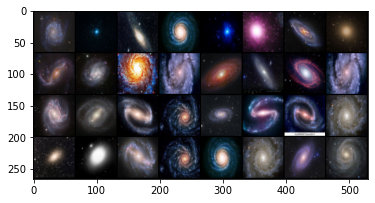

In [6]:
# data loader 
data_loader = getdDataset(config)


for i, (imgs, labels) in enumerate(data_loader):
    print(i, imgs.shape, labels.shape)
    print(labels)

    img = imgs[0]
    img = img.numpy()
    img = make_grid(imgs, normalize=True).numpy()
    img = np.transpose(img, (1, 2, 0))

    plt.imshow(img)
    plt.show()
    plt.close()
    break





In [7]:
# delete the exists path
del_folder(config.sample_path, config.version)
del_folder(config.log_path, config.version)

# create directories if not exist
make_folder(config.sample_path, config.version)
make_folder(config.log_path, config.version)
make_folder(config.sample_path, config.version + '/real_images')
make_folder(config.sample_path, config.version + '/fake_images')

if config.train:
    if config.model == 'dcgan':
        trainer = Trainer_dcgan(data_loader, config)
    trainer.train()
    trainer.save_models()


Generator(
  (l1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (last): Sequential(
    (0): ConvTranspose2d(

In [92]:
#if config.model == 'dcgan':
#    trainer = Trainer_dcgan(data_loader, config)
#    trainer.load_models()


Generator(
  (l1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (last): Sequential(
    (0): ConvTranspose2d(

In [93]:
#trainer.train()

Elapsed [0:00:00.847769], G_step [0/5000], D_step[0/5000], d_out_gp: -1.4330, g_loss: 285.6164, 
saving model
Elapsed [0:00:00.591125], G_step [100/5000], D_step[100/5000], d_out_gp: -3.2414, g_loss: 204.4802, 
Elapsed [0:00:00.598739], G_step [200/5000], D_step[200/5000], d_out_gp: -11.1946, g_loss: 197.8803, 
Elapsed [0:00:00.600330], G_step [300/5000], D_step[300/5000], d_out_gp: -5.5346, g_loss: 186.2878, 
Elapsed [0:00:00.612344], G_step [400/5000], D_step[400/5000], d_out_gp: -8.0755, g_loss: 177.1625, 
Elapsed [0:00:00.608561], G_step [500/5000], D_step[500/5000], d_out_gp: -12.4857, g_loss: 171.7471, 
Elapsed [0:00:00.603893], G_step [600/5000], D_step[600/5000], d_out_gp: -15.2341, g_loss: 171.4297, 
Elapsed [0:00:00.607509], G_step [700/5000], D_step[700/5000], d_out_gp: -8.1717, g_loss: 166.8133, 
Elapsed [0:00:00.602841], G_step [800/5000], D_step[800/5000], d_out_gp: -11.7463, g_loss: 163.6351, 
Elapsed [0:00:00.605138], G_step [900/5000], D_step[900/5000], d_out_gp: -18.3

In [15]:
#trainer.save_models()
trainer.load_models()

Generator(
  (l1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (last): Sequential(
    (0): ConvTranspose2d(

In [44]:

trainer.train()

Elapsed [0:00:00.978275], G_step [0/5000], D_step[0/5000], d_out_gp: -8.0229, g_loss: 6.6057, 
saving model
Elapsed [0:00:00.740468], G_step [100/5000], D_step[100/5000], d_out_gp: -8.5441, g_loss: 7.4226, 
Elapsed [0:00:00.709113], G_step [200/5000], D_step[200/5000], d_out_gp: -8.5773, g_loss: 8.1263, 
Elapsed [0:00:00.721823], G_step [300/5000], D_step[300/5000], d_out_gp: -4.7560, g_loss: 7.3095, 
Elapsed [0:00:00.728705], G_step [400/5000], D_step[400/5000], d_out_gp: -6.0005, g_loss: 8.7509, 
Elapsed [0:00:00.737590], G_step [500/5000], D_step[500/5000], d_out_gp: -7.7704, g_loss: 7.0367, 
Elapsed [0:00:00.745399], G_step [600/5000], D_step[600/5000], d_out_gp: -10.2300, g_loss: 8.7173, 
Elapsed [0:00:00.743125], G_step [700/5000], D_step[700/5000], d_out_gp: -6.6768, g_loss: 8.5229, 
Elapsed [0:00:00.758171], G_step [800/5000], D_step[800/5000], d_out_gp: -9.6458, g_loss: 9.6391, 
Elapsed [0:00:00.730987], G_step [900/5000], D_step[900/5000], d_out_gp: -8.0052, g_loss: 10.5423, 

In [45]:
fixed_z = tensor2var(torch.randn(trainer.batch_size, trainer.z_dim))

In [46]:
pics = trainer.G(fixed_z)

In [47]:
def show_generated(fake_images):
    fig, ax = plt.subplots(figsize=(16,16))
    ax.set_xticks([]); ax.set_yticks([])
    #ax.imshow(make_grid(denorm(fake_images.cpu().detach()), nrow=4).permute(1, 2, 0))
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=4).permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


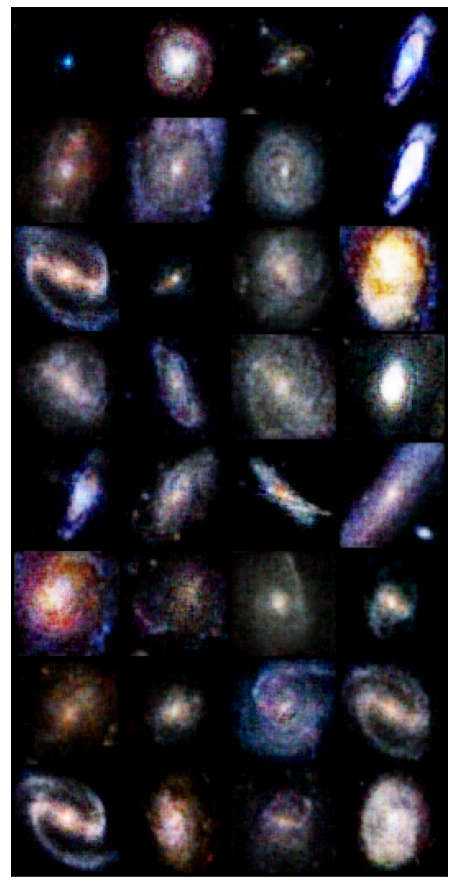

In [48]:
show_generated(pics)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


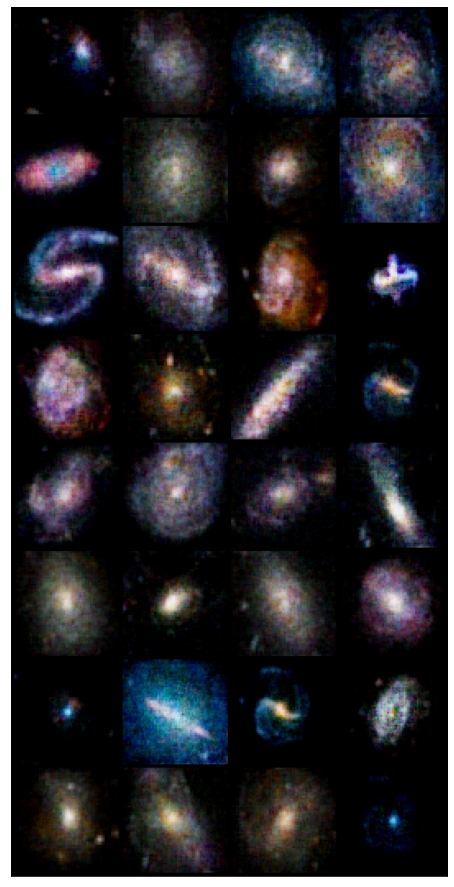

In [49]:
fixed_z = tensor2var(torch.randn(trainer.batch_size, trainer.z_dim))
pics = trainer.G(fixed_z)
show_generated(pics)

$$
\min_G \max_D \mathbf{E}_{x \sim \mathbf{P}_r } [log(D(x)] + \mathbf{E}_{\tilde x \sim \mathbf{P}_g }[ 1- log(D(\tilde x)) ]
$$

where Pr is the data distribution and Pg is the model distribution implicitly defined by x˜ =
G(z), z ∼ p(z) 

$$
G: v \sim \mathcal{N}^k(0,1)  \rightarrow  R^m
$$

$$
D: R^m \rightarrow [0,1]
$$

torch.Size([32, 3, 64, 64])


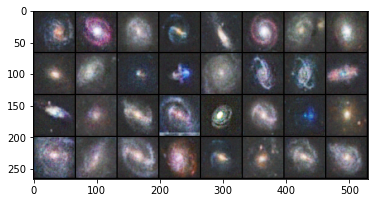

In [53]:
fixed_z = tensor2var(torch.randn(trainer.batch_size, trainer.z_dim))
pics = trainer.G(fixed_z)
img = pics.cpu()
img = img.detach()
print(img.shape)
imgs = []
for i in range(32):
    imgs.append(img[i])
#print(imgs)
img = make_grid(imgs, normalize=True).numpy()
img = np.transpose(img, (1, 2, 0))

plt.imshow(img)
plt.show()
plt.close()

torch.Size([32, 3, 64, 64])


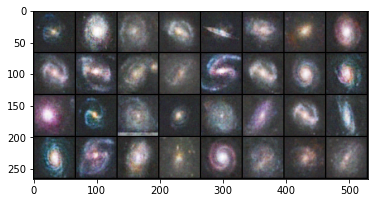

In [54]:
fixed_z = tensor2var(torch.randn(trainer.batch_size, trainer.z_dim))
pics = trainer.G(fixed_z)
img = pics.cpu()
img = img.detach()
print(img.shape)
imgs = []
for i in range(32):
    imgs.append(img[i])
#print(imgs)
img = make_grid(imgs, normalize=True).numpy()
img = np.transpose(img, (1, 2, 0))

plt.imshow(img)
plt.show()
plt.close()